In [91]:
import numpy as np
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

W = LinearSegmentedColormap.from_list('w', ["w", "w"], N=256)

In [92]:
ACTIONS = {
    0: [1, 0],   # north
    1: [-1, 0],  # south
    2: [0, -1],  # west
    3: [0, 1],   # east
}

In [96]:
class Maze:

    def __init__(self):
        np.random.seed(0)
        self.x = 9
        self.y = 6
        self.nA = len(ACTIONS)
        self.Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
        self.Model = defaultdict(list)
        self.Final_Reward = 1
        self.Move_Reward = 0
        self.eps = 0.33
        self.eps_decay = 0.99997
        self.n = 30
        self.old_states = []
        self.alpha = 0.1
        self.alpha_min = 0.01
        self.alpha_decay = 0.9997
        self.discount = 0.97
        self.eps_min = 0.05
        self.final_state = (1,8)
        self.state_values = np.zeros((self.y,self.x))
        self.old_actions = []
        self.policy_values = np.zeros((self.y,self.x),dtype=str)
        self.count_timestep = 0

    def reset(self):
        state = (0,2)
        return state

    def step(self,state,action):
        done = False
        if state == (0,8):
            done = True
            reward = self.Final_Reward
            return state,reward,done

        next_state = (state[0]+action[0],state[1]+action[1])
        reward = self.Move_Reward

        if next_state == (1,2) or next_state == (2,2) or next_state == (3,2) or next_state == (4,5) or next_state == (0,7) or next_state == (1,7) or next_state == (2,7):
            next_state = state

        if next_state[0]<0 or next_state[0]>=self.y:
            next_state = state

        if next_state[1]<0 or next_state[1]>=self.x:
            next_state = state 

        return next_state,reward,done

    def get_action_prob(self,Q_S):

        action_probs = np.ones(self.nA)*(self.eps/self.nA)
        best_action = np.argmax(Q_S)
        action_probs[best_action] += (1-self.eps)

        return action_probs
    
    def get_action(self,state):

        action_prob = self.get_action_prob(self.Q[state])
        _action_ = np.random.choice(np.arange(self.nA),p = action_prob)
        # action = ACTIONS.get(_action_)

        return _action_

    def best_policy(self):

        return dict((state, np.argmax(actions)) for state,actions in self.Q.items())

    def best_value(self):

        return dict((state, np.max(actions)) for state,actions in self.Q.items())


    def Dyna_Maze(self,alpha):

        state = self.reset()
        self.count_timestep = 0
        _action_ = self.get_action(state)

        #Getting action from dictionary 
        action = ACTIONS.get(_action_)

        while True:

            next_state,reward,done = self.step(state,action)

            self.Q[state][_action_] +=  alpha*(reward + (self.discount*np.max(self.Q[next_state])) - self.Q[state][_action_])

            state_action = (state,_action_)
            self.Model[state_action] = (reward,next_state)

            state = next_state
            _action_ = self.get_action(state)
            action = ACTIONS.get(_action_)
            # time.sleep(1)

            # print(self.Q)
            # print(self.Model)
            # time.sleep(2)

            if done:
                break
            print("In Loop {:.5f}".format(self.count_timestep), end="\r")
            self.count_timestep +=1 

            for i in range(self.n):
                
                #Selecting Random State
                states_visited = []
                for x in self.Q.keys():
                    states_visited.append(x)

                random_state = states_visited[np.random.randint(0,len(states_visited))]

                #Selecting Random Action
                actions_dict_1 = {}
                actions_dict_2 = {} 

                for j,x in enumerate(self.Q[random_state]):
                    actions_dict_1.update({j:x})
                
                for j,x in actions_dict_1.items():
                    if x!= 0:
                        actions_dict_2.update({j:x})

                ava_actions = []

                for j,x in actions_dict_2.items():
                    ava_actions.append(j)

                if len(ava_actions)!=0:
                    random_action = np.random.choice(ava_actions)

                    random_state_random_action = (random_state,random_action)
                    _reward_,_next_state_ = self.Model[random_state_random_action]
                    self.Q[random_state][random_action] += alpha*(_reward_ + self.discount*np.max(self.Q[_next_state_])- self.Q[random_state][random_action])
        
        return self.Model,self.Q

    def loop(self):

        Episdoes = []
        TimeSteps = []

        #Reseting 
        self.Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
        self.Model = defaultdict(list)

        for x in range(50):
            print("In Loop {:.5f}".format(x), end="\r")
            # self.eps = max(self.eps_min,self.eps*self.eps_decay)
            # self.alpha = max(self.alpha_min,self.alpha*self.alpha_decay)
            self.Model,self.Q = self.Dyna_Maze(self.alpha)
            if x!=0:
                Episdoes.append(x)
                TimeSteps.append(self.count_timestep)

        policy_initial = self.best_policy()
        policy = self.Real_Actions(policy_initial)

        value_initial = self.best_value()
        self.state_values = self.Real_Value(value_initial)

        #Plots
        # self.render()
 

        return Episdoes,TimeSteps

    def plot_diffrent_n(self):

        #N = 0
        self.n = 0
        print('Going through N:0')
        Eps_N_0,T_N_0 = self.loop()

        #N = 5
        self.n = 5
        print('Going through N:5')
        Eps_N_5,T_N_5 = self.loop()

        #N = 50
        self.n = 50
        print('Going through N:50')
        EPS_N_50,T_N_50 = self.loop()

        #Episodes VS TimeSteps 
        plt.figure(figsize=(13,9))
        plt.plot(Eps_N_0,T_N_0)
        plt.plot(Eps_N_5,T_N_5)
        plt.plot(EPS_N_50,T_N_50)
        plt.ylim(0,800)
        plt.title('Time Step vs Episodes')
        plt.xlabel('Episodes')
        plt.ylabel('TimeSteps')
        plt.show()



    def render(self, title=None):
        """
        Displays the current value table of mini gridworld environment
        """
        size = len(self.state_values) if len(self.state_values) < 20 else 20
        fig, ax = plt.subplots(figsize=(self.x, self.y))
        if title is not None:
            ax.set_title(title)
        ax.grid(which='major', axis='both',
                linestyle='-', color='k', linewidth=2)
        sn.heatmap(self.state_values, annot=True, fmt=".1f", cmap=W,
                   linewidths=1, linecolor="black", cbar=False)
        plt.show()
        return fig, ax


    def Real_Actions(self,policy):
        y = []

        for x in policy:
            y.append(x)

        policy_actions = {}

        for x in y:

            action = policy.get(x)
   
            if action == 0:
                policy_actions.update({x:'South'})
            if action  == 1:
                policy_actions.update({x:'North'})
            if action  == 2:
                policy_actions.update({x:'West'})
            if action  == 3:
                policy_actions.update({x:'East'})

        return policy_actions

    def Real_Value(self,value):

        for x in value.items():
            self.state_values[x[0]] = x[1]

        return self.state_values


    

In [97]:
env = Maze()

Going through N:0
Going through N:5
Going through N:50


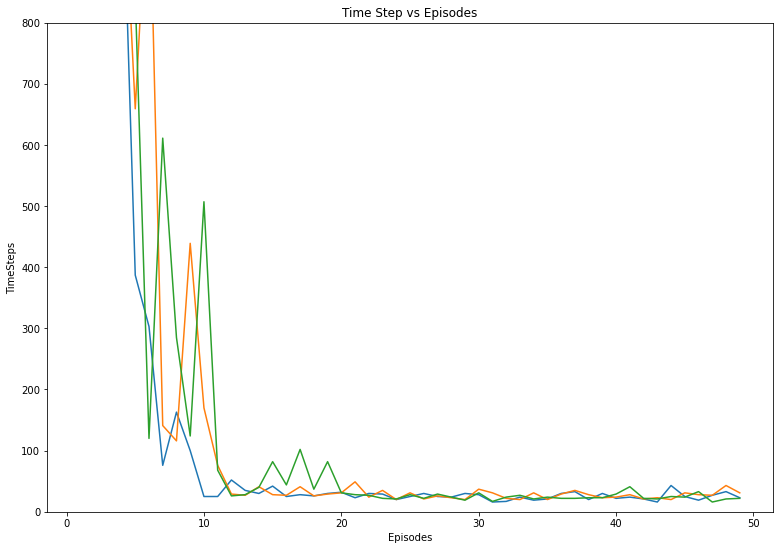

In [98]:
env.plot_diffrent_n()

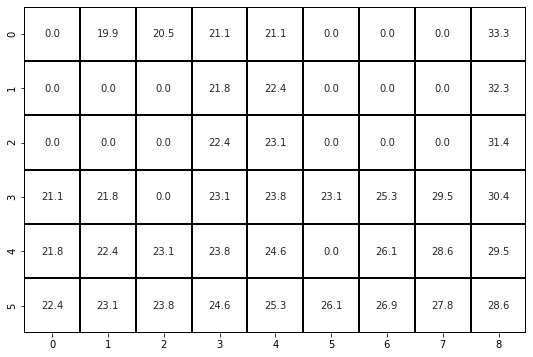

(<Figure size 648x432 with 1 Axes>, <AxesSubplot:>)

In [99]:
env.render()